**3c-A — Fit Two Parameters (Planet Radius + Mid-transit Time)**

Instead of just rp, let’s fit radius ratio (Rp/Rs) and mid-transit time (t0).

In [1]:
import batman
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# -----------------
# Step 1: Define true transit parameters
# -----------------
true_params = {
    "t0": 0.0,          # mid-transit time [days]
    "per": 1.0,         # orbital period [days]
    "rp": 0.1,          # planet radius (in stellar radii)
    "a": 15.0,          # semi-major axis (in stellar radii)
    "inc": 87.0,        # inclination [deg]
    "ecc": 0.0,         # eccentricity
    "w": 90.0,          # longitude of periastron
    "limb_dark": "quadratic", # limb darkening model
    "u": [0.1, 0.3]     # limb darkening coefficients
}

# Create parameter object
m_true = batman.TransitParams()
for k, v in true_params.items():
    setattr(m_true, k, v)

# Time grid
t = np.linspace(-0.05, 0.05, 500)

# Synthetic light curve
model_true = batman.TransitModel(m_true, t)
flux_true = model_true.light_curve(m_true)

# Add noise
rng = np.random.default_rng(42)
flux_obs = flux_true + rng.normal(0, 0.0005, size=len(flux_true))


In [2]:
# -----------------
# Step 2: Define fitting model (vary rp, t0)
# -----------------
def transit_model_fit(t, rp, t0):
    m = batman.TransitParams()
    for k, v in true_params.items():
        setattr(m, k, v)
    m.rp = rp
    m.t0 = t0
    model = batman.TransitModel(m, t)
    return model.light_curve(m)

In [3]:
# -----------------
# Step 3: Fit both parameters
# -----------------
popt, pcov = curve_fit(
    transit_model_fit, t, flux_obs,
    p0=[0.12, 0.01],        # initial guesses
    bounds=([0.01, -0.02], [0.5, 0.02])  # limits
)
rp_fit, t0_fit = popt
rp_err, t0_err = np.sqrt(np.diag(pcov))

print(f"True Rp/Rs = {true_params['rp']:.3f}")
print(f"Fit Rp/Rs  = {rp_fit:.3f} ± {rp_err:.3f}")
print(f"True t0    = {true_params['t0']:.3f}")
print(f"Fit t0     = {t0_fit:.4f} ± {t0_err:.4f}")

True Rp/Rs = 0.100
Fit Rp/Rs  = 0.100 ± 0.000
True t0    = 0.000
Fit t0     = 0.0000 ± 0.0000


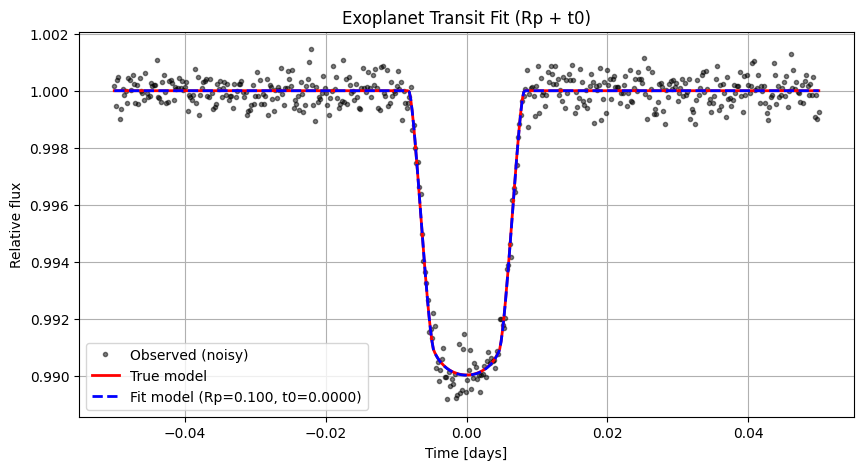

In [4]:
# -----------------
# Step 4: Plot results
# -----------------
plt.figure(figsize=(10,5))
plt.plot(t, flux_obs, 'k.', alpha=0.5, label="Observed (noisy)")
plt.plot(t, flux_true, 'r-', lw=2, label="True model")
plt.plot(t, transit_model_fit(t, rp_fit, t0_fit), 'b--', lw=2,
         label=f"Fit model (Rp={rp_fit:.3f}, t0={t0_fit:.4f})")

plt.xlabel("Time [days]")
plt.ylabel("Relative flux")
plt.title("Exoplanet Transit Fit (Rp + t0)")
plt.legend()
plt.grid(True)
plt.show()

Now we’ll recover both the planet radius and mid-transit time, with uncertainties.

**Module 3c-B — Use Real Kepler/TESS Data**

For real data, we’ll use the lightkurve library (built for Kepler/K2/TESS).

SearchResult containing 50 data products.

 #       mission      year   author   exptime         target_name          distance
                                         s                                  arcsec 
--- ----------------- ---- ---------- ------- ---------------------------- --------
  0 Kepler Quarter 02 2009     Kepler      60                kplr011904151      0.0
  1 Kepler Quarter 03 2009     Kepler      60                kplr011904151      0.0
  2 Kepler Quarter 03 2009     Kepler      60                kplr011904151      0.0
  3 Kepler Quarter 03 2009     Kepler      60                kplr011904151      0.0
  4 Kepler Quarter 00 2009     Kepler    1800                kplr011904151      0.0
  5 Kepler Quarter 01 2009     Kepler    1800                kplr011904151      0.0
  6 Kepler Quarter 02 2009     Kepler    1800                kplr011904151      0.0
  7 Kepler Quarter 03 2009     Kepler    1800                kplr011904151      0.0
  8 Kepler Quarter 07 2010     Ke

c:\Users\nicek\anaconda3\envs\anaconda-toolbox\Lib\site-packages\lightkurve\search.py:420: LightkurveWarning: Warning: 50 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


<Figure size 1000x500 with 0 Axes>

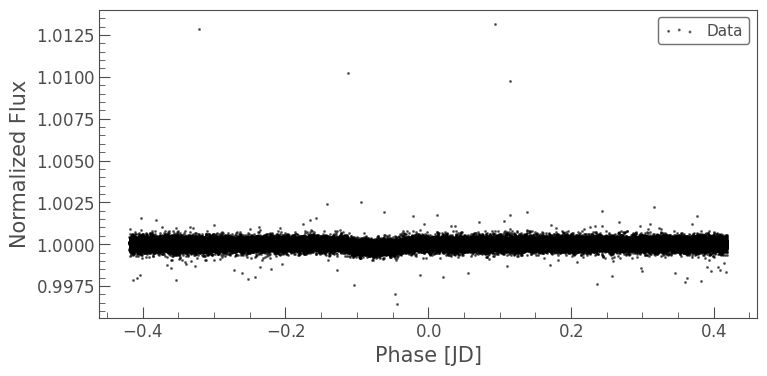

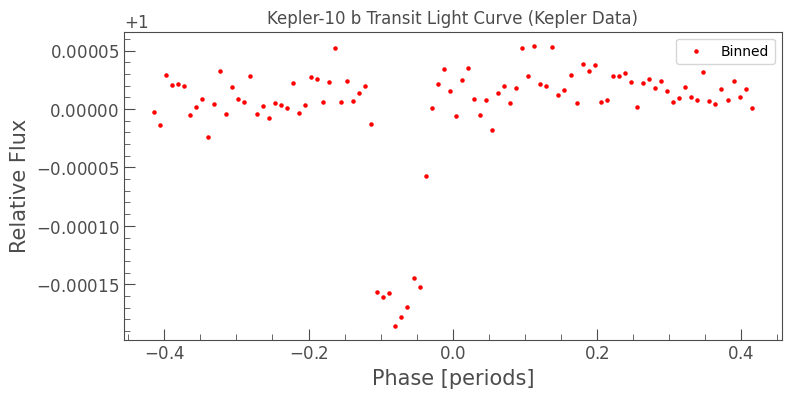

In [6]:
import lightkurve as lk
import matplotlib.pyplot as plt

# Step 1: Search Kepler data for Kepler-10
search = lk.search_lightcurve("Kepler-10", mission="Kepler")
print(search)   # see what’s available

# Step 2: Download first available light curve
lc = search.download()

# Step 3: Clean + normalize
if lc is None:
    raise ValueError("No light curve found. Try a different star or mission.")

lc = lc.remove_nans().normalize()

# Step 4: Fold on known orbital period
period = 0.8375  # Kepler-10 b period in days
folded_lc = lc.fold(period=period)

# Step 5: Plot
plt.figure(figsize=(10,5))
folded_lc.scatter(color="k", alpha=0.5, s=5, label="Data")
folded_lc.bin(bins=100).scatter(color="red", s=20, label="Binned")

plt.xlabel("Phase [periods]")
plt.ylabel("Relative Flux")
plt.title("Kepler-10 b Transit Light Curve (Kepler Data)")
plt.legend()
plt.show()


